# 1. Importing Packages

In [22]:
from qiskit import QuantumCircuit,Aer,execute,IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

# 2. Building the Grover search Algorihtm circuit
<!---defining ket notation for redering--->
 $\newcommand{\ket}[1]{\left|#1\right>}$
 
We're building the grover three qubit search algorithm.

Here we will be marking two states as our target states which we  want to search for<br><br>
$$\ket{101} and \ket{110}$$ 

and hence our oracle will be marking these two states with a -1 phase

Our strategy still remains the same as with the two qubit:

> Reflecting the $\ket{s}$, twice, first around $\ket{s^|}$ and then around itself $\ket{s}$

In [9]:
def istate(qc):
    for q in range(qc.num_qubits):
        qc.h(q)
    qc.barrier()
    return qc

def oracle(qc):
    qc.cz(2,0)
    qc.cz(1,0)
    qc.barrier()
    return qc

def ref_op(qc):
    for q in range(qc.num_qubits):
        qc.h(q)
        qc.x(q)
    
    #making CCZ transformation
    qc.h(0)
    qc.ccx(1,2,0)
    qc.h(0)
    #done
    
    for q in range(qc.num_qubits):
        qc.x(q)
        qc.h(q)
    return qc

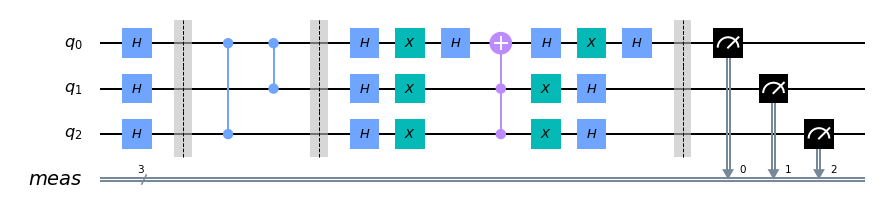

In [13]:
qc=QuantumCircuit(3)
qc=istate(qc)
qc=oracle(qc)
qc=ref_op(qc)
qc.measure_all()
qc.draw('mpl')

# 3. Running our circuit

## 3.1 QASM simulator

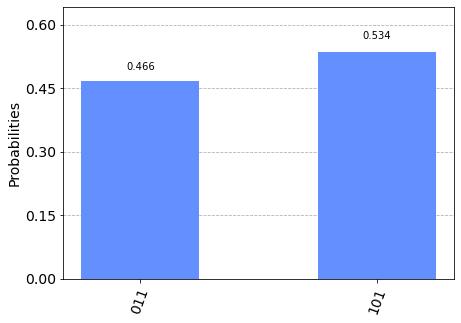

In [16]:
qasm_simulator = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(qc, backend=qasm_simulator, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

## 3.2 Real Device

In [23]:
provider= IBMQ.load_account()
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

C:\Users\deathstroke\.conda\envs\13aug_tf-gpu-cuda8\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


Running on current least busy device:  ibmq_valencia


In [24]:
job = execute(qc, backend=device, shots=1024, optimization_level=3)
job_monitor(job, interval = 2)

Job Status: job has successfully run


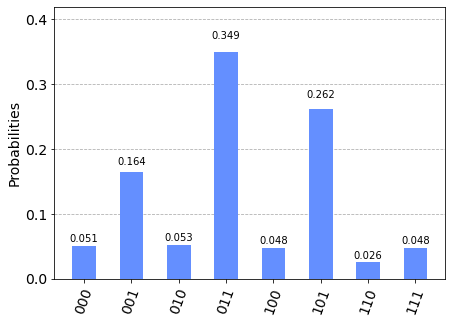

In [36]:
results = job.result()
answer = results.get_counts()
plot_histogram(answer)

We have gotten the right answers but the error rates are quite high therefore multiple runs of these alrorithm or error correction code might be required

# 4. Mitigating Noise

In [26]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

In [27]:
cal_circuits,state_labels = complete_meas_cal(qr=qc.qregs[0],circlabel='measerrormitigationcal')

In [30]:
provider=IBMQ.get_provider('ibm-q')
rbackend=provider.get_backend('ibmq_valencia')
cal_jobs=execute(cal_circuits,
                backend=rbackend,
                shots=1024,
                optimization_level=0)
print(cal_jobs.job_id())
job_monitor(cal_jobs)
cal_results=cal_jobs.result()

5f5c547d6b0348001a9aad5d
Job Status: job has successfully run


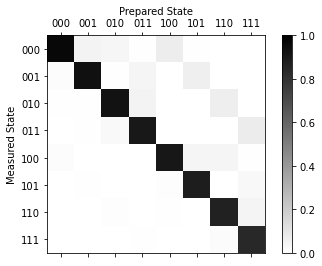

In [31]:
meas_fitter=CompleteMeasFitter(cal_results,state_labels)
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter

## Unknown Error in ignis package(waiting to be resolved)

In [37]:
mitigated_result = meas_filter.apply(results)
device_counts = results.get_counts()
mitigated_counts= mitigated_result.get_counts()
plot_histogram([device_counts,mitigated_counts], legend=["device counts","device counts mitigated"])

AttributeError: 'dict' object has no attribute '__dict__'